# Project 2: Crash prediction

### Duc Vu - ducvuchicago@gmail.com
Part 3/3 - Exploratory data analysis and linear regression modeling for predicting car accident

Process:

- Exploratory Data Analysis

- Regression Modeling

- Predicting Real Test Cases


Packages:

- `pandas`: for data frames

- `seaborn` : for statistical data visualization

- `scipy` : for mathematical functions.

- `dbfread` : for reading DBF files and returning the data as native Python data types

- `statsmodels` : for statistical models, and perform statistical tests

- `sklearn` : for machine learning library 

In [1]:
# neccessary library
%pylab inline
#%config InlineBackend.figure_formats = ['svg']
%config InlineBackend.figure_formats = ['retina']

import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import patsy
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


## A. Exploratory Data Analysis

In [2]:
df=pd.read_pickle('./dataset/input.pkl')

df.columns = map(str.lower, df.columns)
# drop NaNs for quick analysis
df=df.dropna()
#df.describe()
print(len(df))
df.head()

720


,num_accident,darkness,not darkness,percent_accident_at_night,not snow,snow,percent_accident_in_snow,lat,lng,zipcode_location,...,population,density,num_potholes,non traffic,traffic,percent_traffic_related_crime,intersection_count,num_crime,zipcode,month
144,81.0,35.0,46.0,0.432099,64.0,17.0,0.209877,41.88526,-87.62194,"(41.885259999999995, -87.62194000000001)",...,11110.0,11892.3,48.0,104.0,29.0,0.218045,119.0,133.0,60601,1.0
145,60.0,28.0,32.0,0.466667,55.0,5.0,0.083333,41.88526,-87.62194,"(41.885259999999995, -87.62194000000001)",...,11110.0,11892.3,406.0,75.0,27.0,0.264706,119.0,102.0,60601,2.0
146,81.0,33.0,48.0,0.407407,80.0,1.0,0.012346,41.88526,-87.62194,"(41.885259999999995, -87.62194000000001)",...,11110.0,11892.3,424.0,104.0,28.0,0.212121,119.0,132.0,60601,3.0
147,93.0,26.0,67.0,0.279570,92.0,1.0,0.010753,41.88526,-87.62194,"(41.885259999999995, -87.62194000000001)",...,11110.0,11892.3,257.0,87.0,38.0,0.304000,119.0,125.0,60601,4.0
148,87.0,22.0,65.0,0.252874,87.0,0.0,0.000000,41.88526,-87.62194,"(41.885259999999995, -87.62194000000001)",...,11110.0,11892.3,446.0,123.0,40.0,0.245399,119.0,163.0,60601,5.0


In [3]:
df['id'] = df[['zipcode', 'month']].apply(lambda x: (x[0], x[1]), axis=1)

In [4]:
df.columns

Index(['num_accident', 'darkness', 'not darkness', 'percent_accident_at_night',
       'not snow', 'snow', 'percent_accident_in_snow', 'lat', 'lng',
       'zipcode_location', 'city', 'state_name', 'population', 'density',
       'num_potholes', 'non traffic', 'traffic',
       'percent_traffic_related_crime', 'intersection_count', 'num_crime',
       'zipcode', 'month', 'id'],
      dtype='object')

In [5]:
subset_all = ['num_accident', 'darkness', 'not darkness', 'percent_accident_at_night',
       'not snow', 'snow', 'percent_accident_in_snow', 'lat', 'lng',
       'population', 'density', 'num_potholes', 'non traffic', 'traffic',
       'percent_traffic_related_crime', 'num_traffic_related_crime', 'intersection_count']


subset = ['num_accident', 'percent_accident_at_night', 'percent_accident_in_snow', 'lat', 'lng',
          'population', 'density', 'num_potholes', 'percent_traffic_related_crime', 
          'num_crime',  'intersection_count']

### A1.  Pairwise scatter plots and correlation heatmap for checking multicollinearity

<img src="./images/pairplot.png",width=60,height=60>

In [6]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "./images/pairplot.png")

### A2. Heatmap plot with num_accident against other features

Text(0.5, 1, 'Correlation matrix')

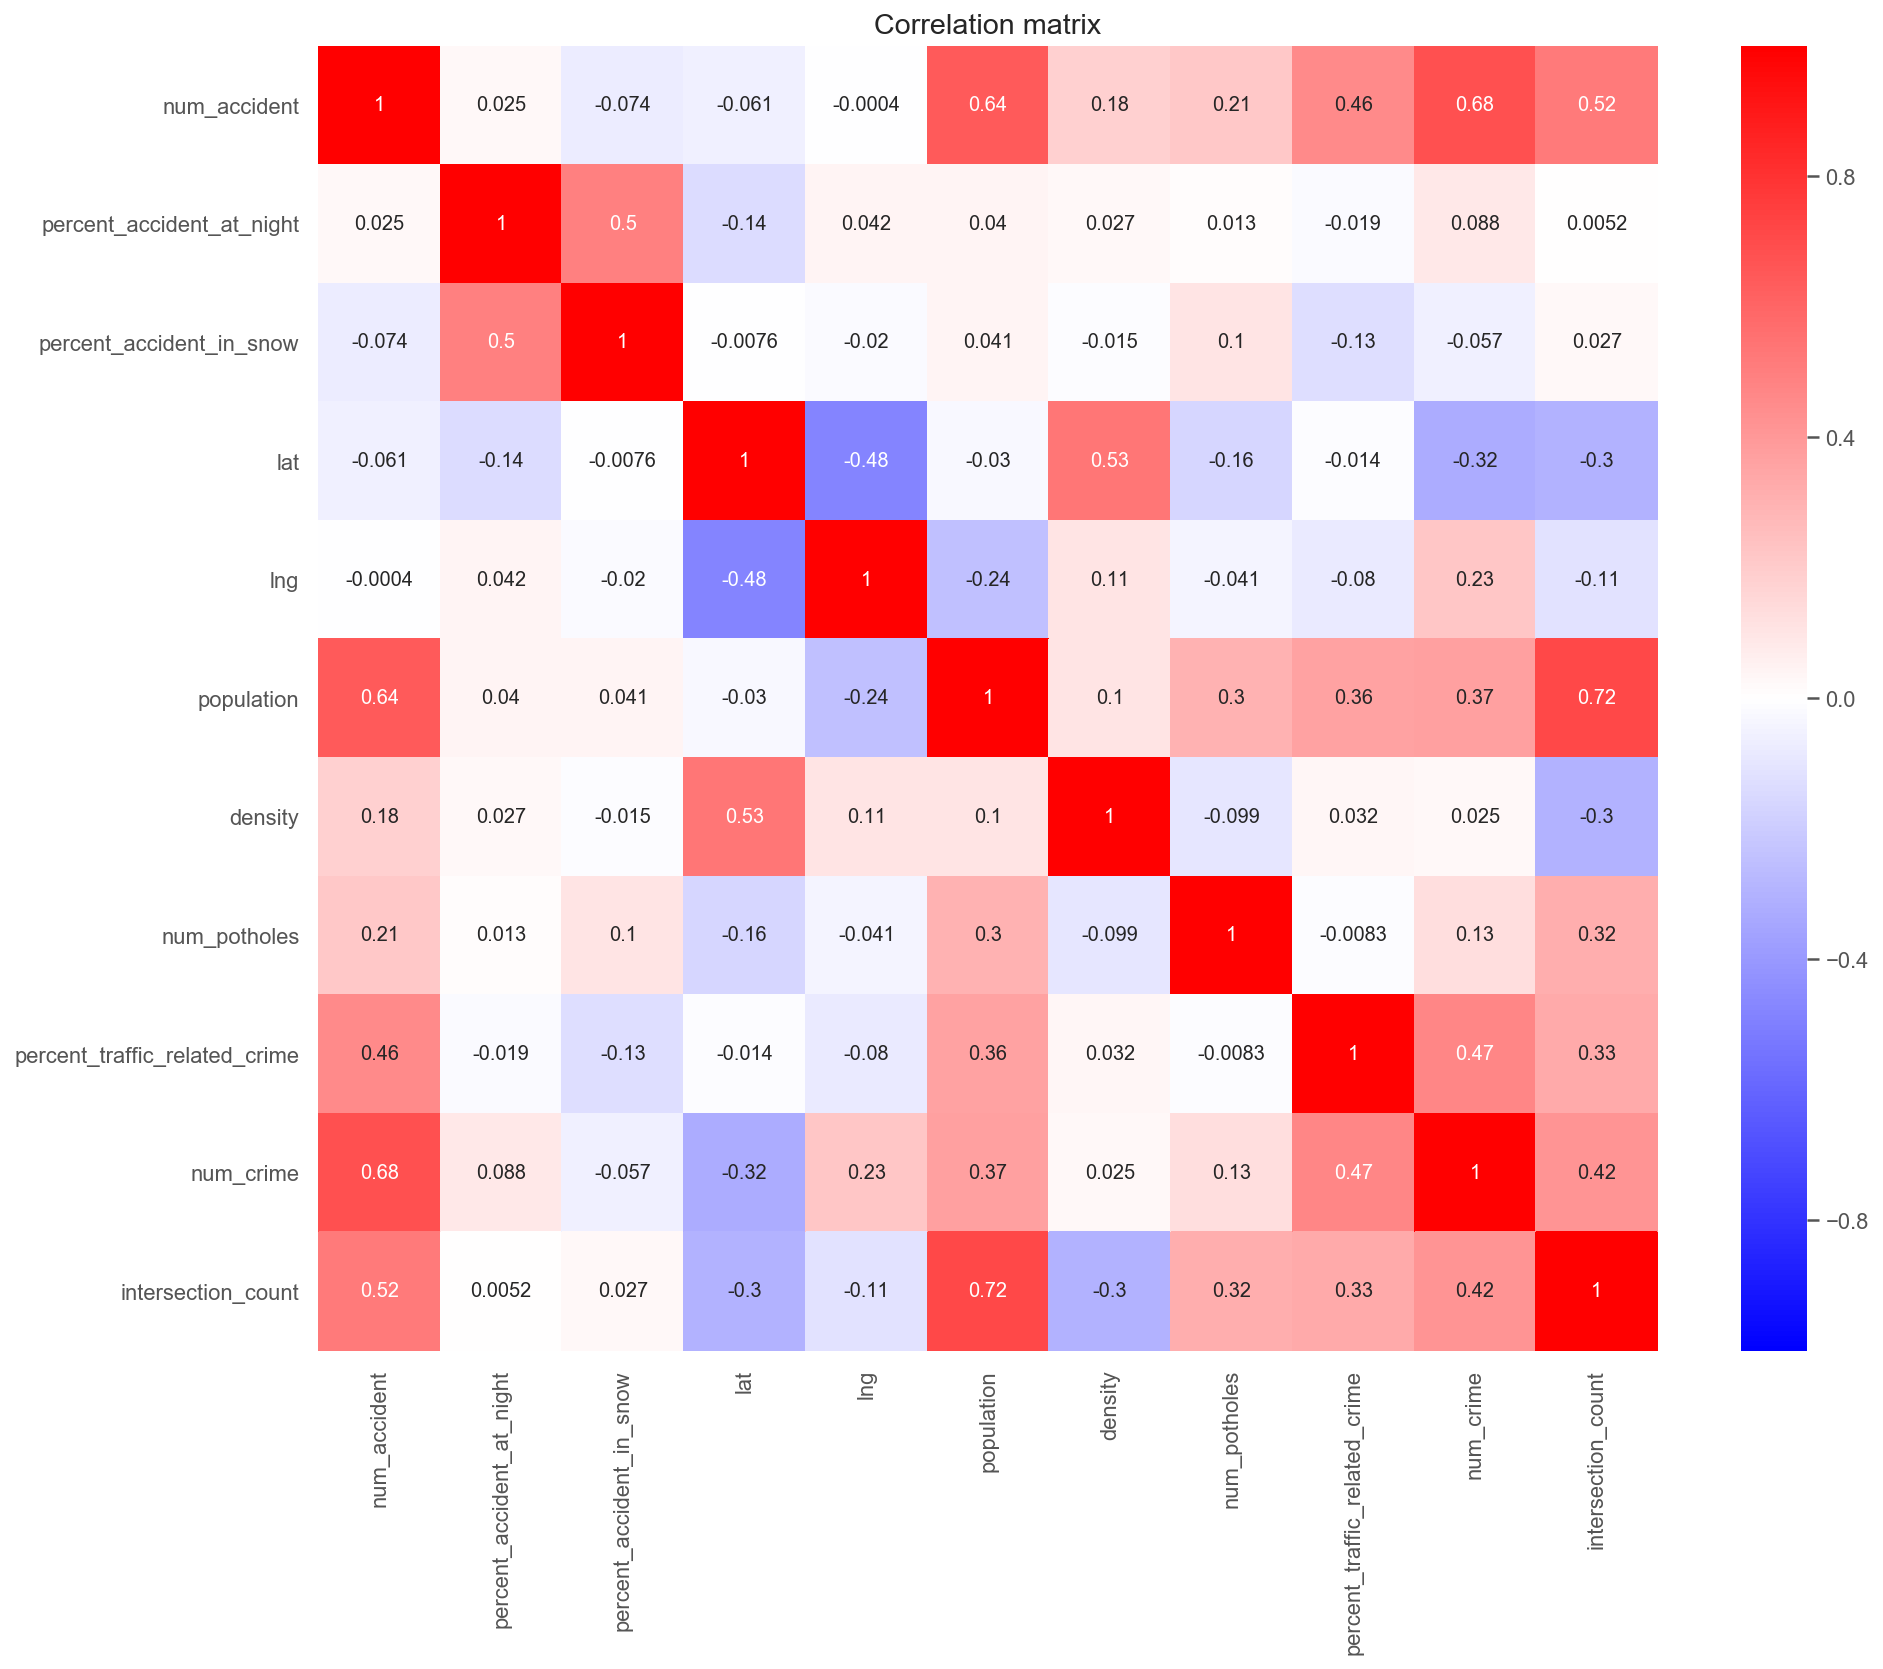

In [7]:
plt.figure(figsize=(15, 12))
sns.heatmap(df[subset].corr(), cmap="bwr", annot=True, vmin=-1, vmax=1)
plt.title('Correlation matrix')

### A3. Number of accidents vs Number of potholes in Chicago

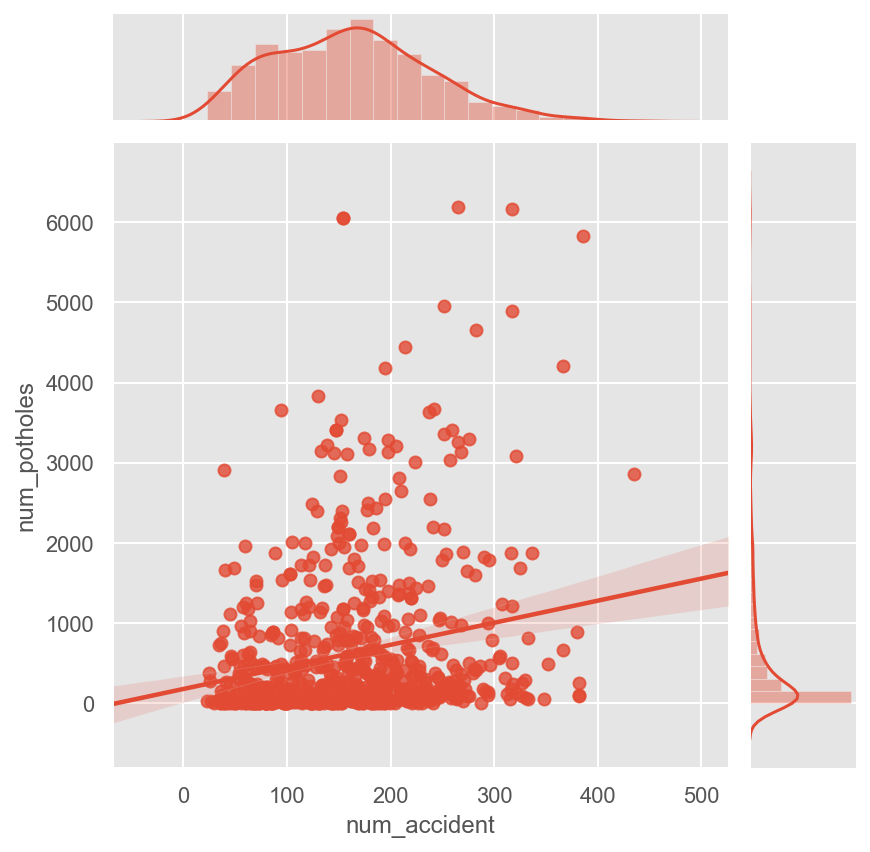

In [8]:
sns.jointplot('num_accident', 'num_potholes', kind="regplot", data=df) 

### A4. Number of accidents vs Number of intersections in Chicago

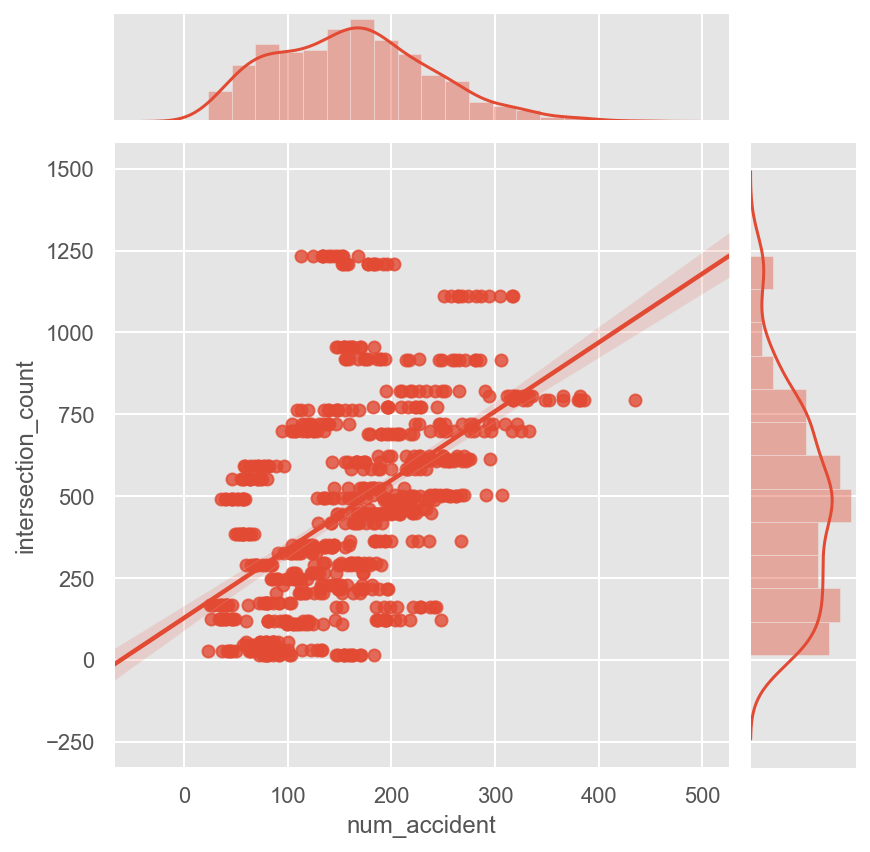

In [9]:
sns.jointplot('num_accident', 'intersection_count', kind="regplot", data=df) 

### A5. Number of accidents vs Population in Chicago

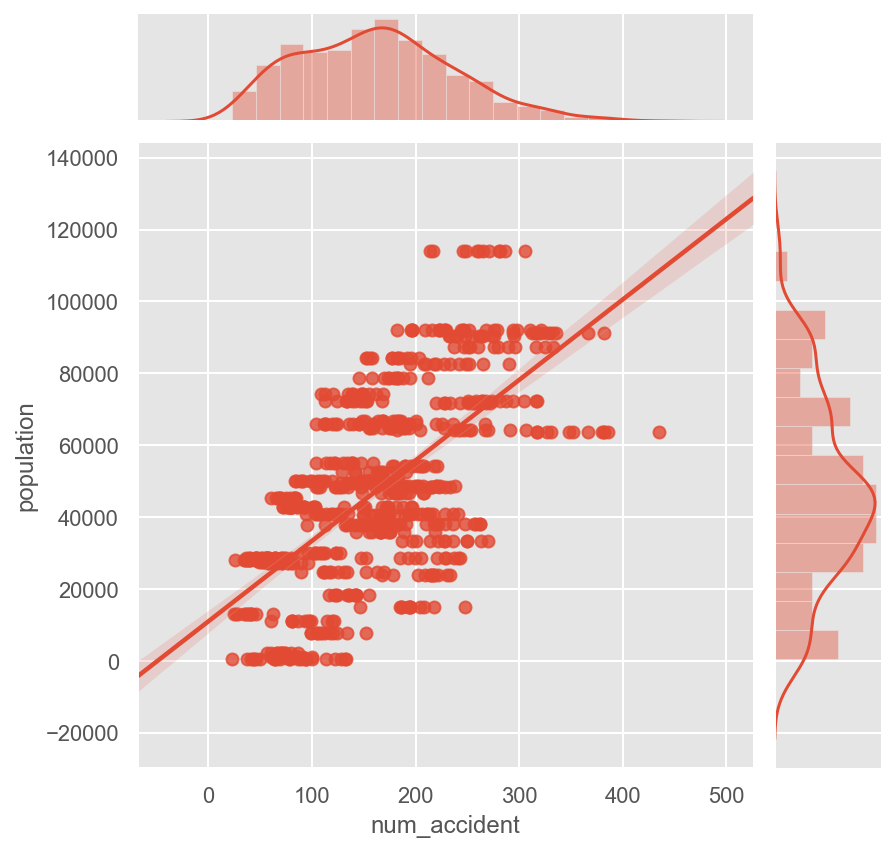

In [10]:
sns.jointplot('num_accident', 'population', kind="regplot", data=df) 

### A6. Ideal correlation: Number of accidents vs Number of crimes in Chicago

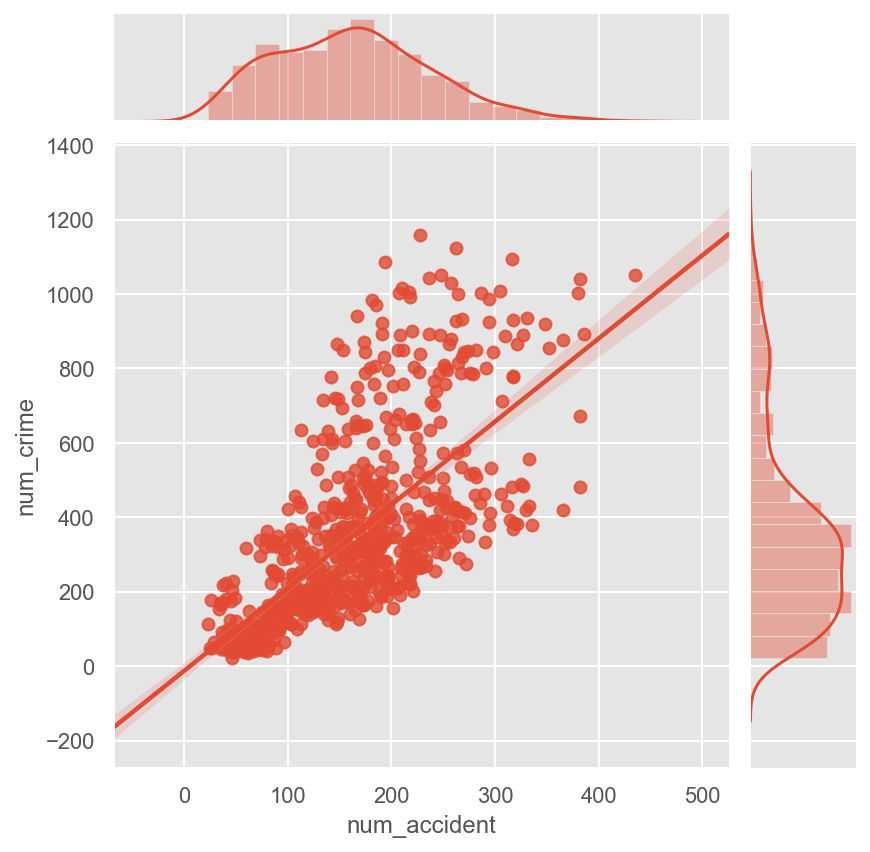

In [11]:
sns.jointplot('num_accident', 'num_crime', kind="regplot", data=df) 
#sns.relplot('num_accident', 'num_crime', kind="scatter", data=df, color='green');

### A7. Plot histogram of dependent variable to check if it is normal distribution

Text(0.5, 1.0, 'Histogram of target')

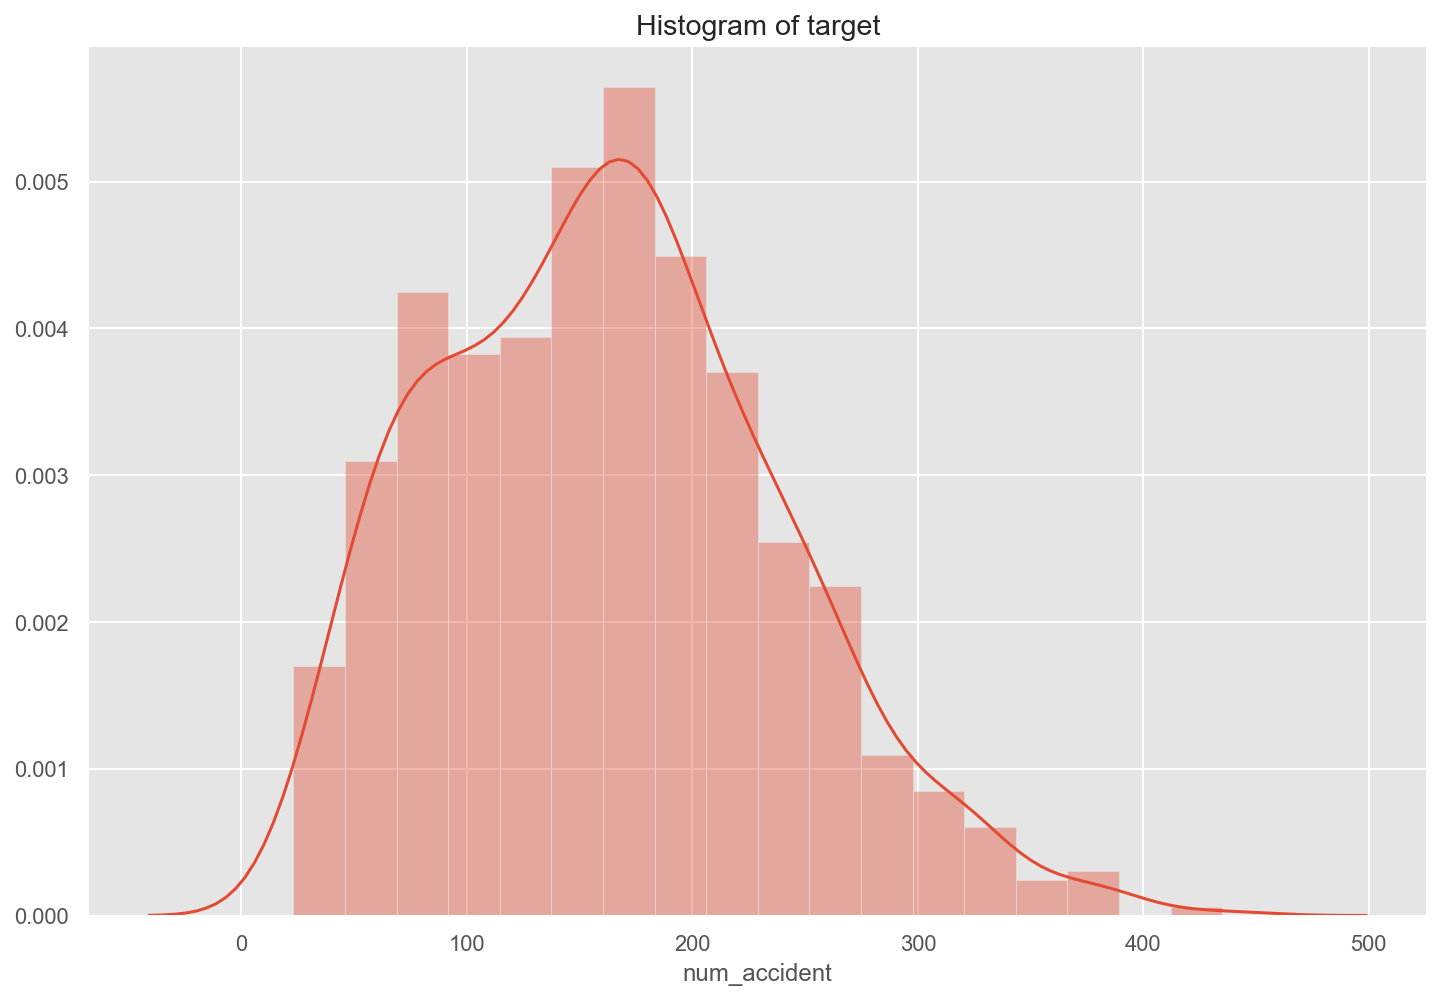

In [12]:
plt.figure(figsize=(12, 8))
sns.distplot(df['num_accident'])
plt.title('Histogram of target')

## B. Regression Models

### B1. Load Data

In [13]:
features = ['percent_accident_at_night', 'percent_accident_in_snow', 'lat', 'lng',
            'population', 'density', 'num_potholes', 'percent_traffic_related_crime', 
            'num_crime',  'intersection_count']

target = ['num_accident']

#Separate our features from our target
#X = df.loc[:,features]

X = df[features]
y = df[target]

In [14]:
X.shape, y.shape

((720, 10), (720, 1))

### B2. Baseline model

In [15]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    train_score = lr_model.score(X_train, y_train)
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nTrain R^2 score was:', train_score)
    print('\nValidation R^2 score was:', val_score)
    print('\nFeature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_[0]):
        print(feature, ':', f'{coef:.2f}') 

split_and_validate(X, y)


Train R^2 score was: 0.6717622381724969

Validation R^2 score was: 0.6752109416359127

Feature coefficient results: 

percent_accident_at_night : 26.41
percent_accident_in_snow : -75.85
lat : 73.92
lng : 30.70
population : 0.00
density : 0.00
num_potholes : 0.00
percent_traffic_related_crime : 56.00
num_crime : 0.15
intersection_count : 0.02


In [16]:
# hold out 60%, 20% and 20% of  for the train, validation and test data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.20, random_state=3)

### Run simple linear regression model

In [17]:
## Add constant and use StatsModels to generate an OLS regression model
model_1 = sm.OLS(y_train_val, sm.add_constant(X_train_val))
model_1_fit = model_1.fit()
model_1_fit.summary()

/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           num_accident   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     109.9
Date:                Sat, 20 Jul 2019   Prob (F-statistic):          1.64e-125
Time:                        04:44:13   Log-Likelihood:                -2992.0
No. Observations:                 576   AIC:                             6006.
Df Residuals:                     565   BIC:                             6054.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           482.8633   3097.624      0.156      0.876   -5601.401    6567.127
percent_accident_at_night        -0.6778     21.905     -0.031      0.975     -43.702      42.347
percent_accident_in_snow        -46.3399     28.818     -1.608      0.108    -102.943      10.263
lat                              80.7891     33.932      2.381      0.018      14.141     147.437
lng                              43.8947     43.581      1.007      0.314     -41.706     129.495
population                        0.0010      0.000      8.217      0.000       0.001       0.001
density                           0.0028      0.001      2.994      0.003       0.001       0.005
num_potholes                      0.0022      0.002      1.036      0.301      -0.002       0.006
percent_traffic_related_crime    58.3126     28.415      2.052      0.041       2.501     114.124
num_crime                         0.1485      0.010     14.358      0.000       0.128       0.169
intersection_count                0.0282      0.011      2.606      0.009       0.007       0.050
==============================================================================
Omnibus:                       26.012   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.695
Skew:                           0.475   Prob(JB):                     3.56e-07
Kurtosis:                       3.580   Cond. No.                     9.16e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.16e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Residuals vs. predicting variables plots')

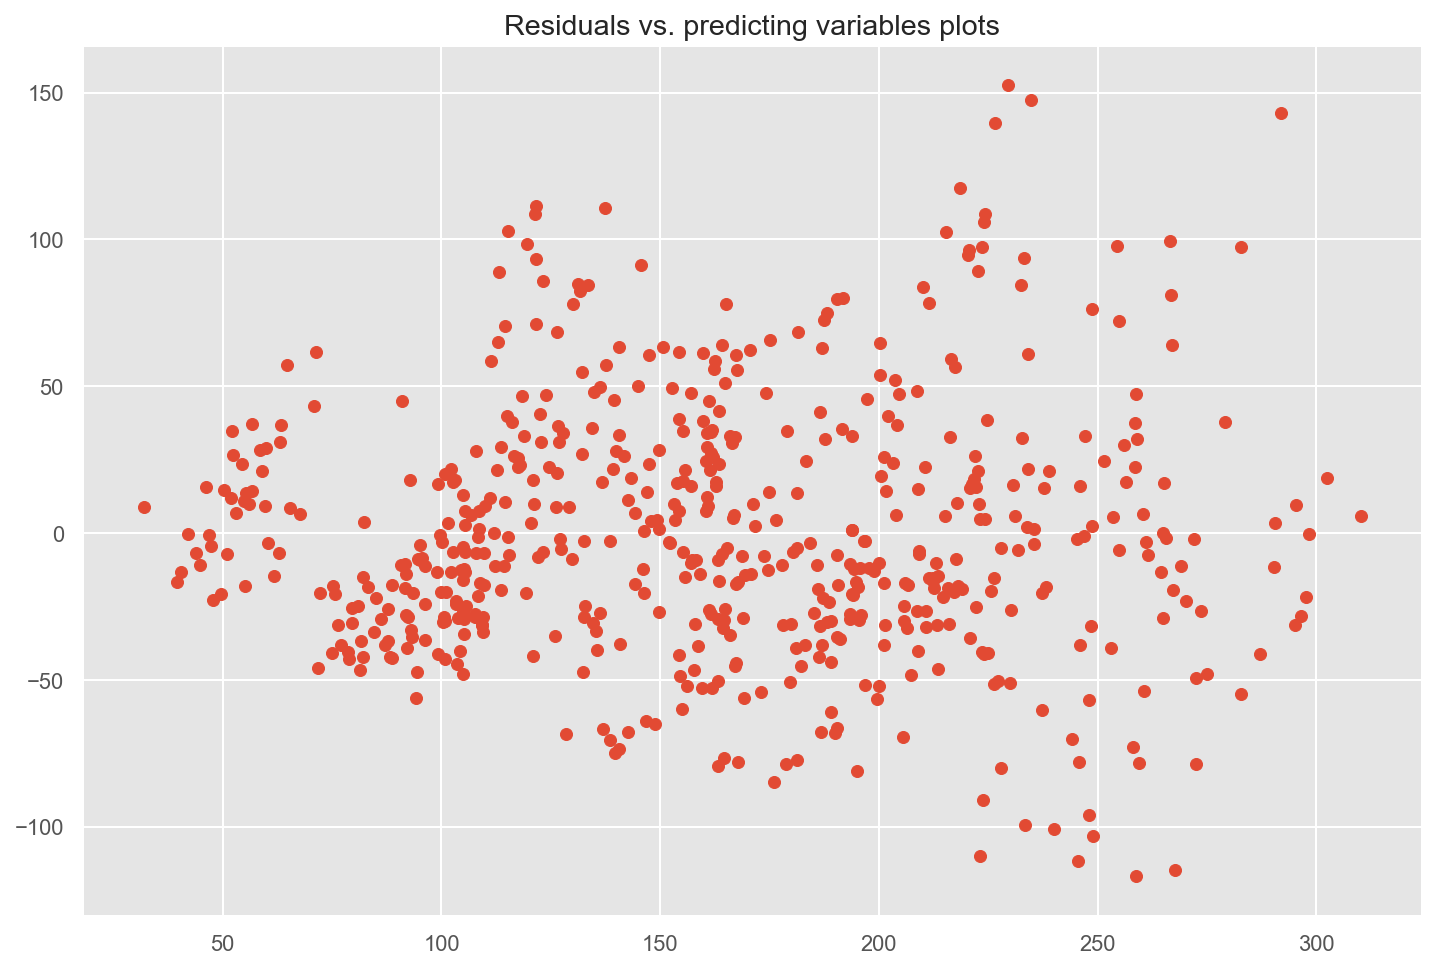

In [18]:
plt.figure(figsize=(12,8))
plt.scatter(model_1_fit.predict(), model_1_fit.resid);
plt.title('Residuals vs. predicting variables plots')

### Check the quality of regression model by plotting residual and prediction

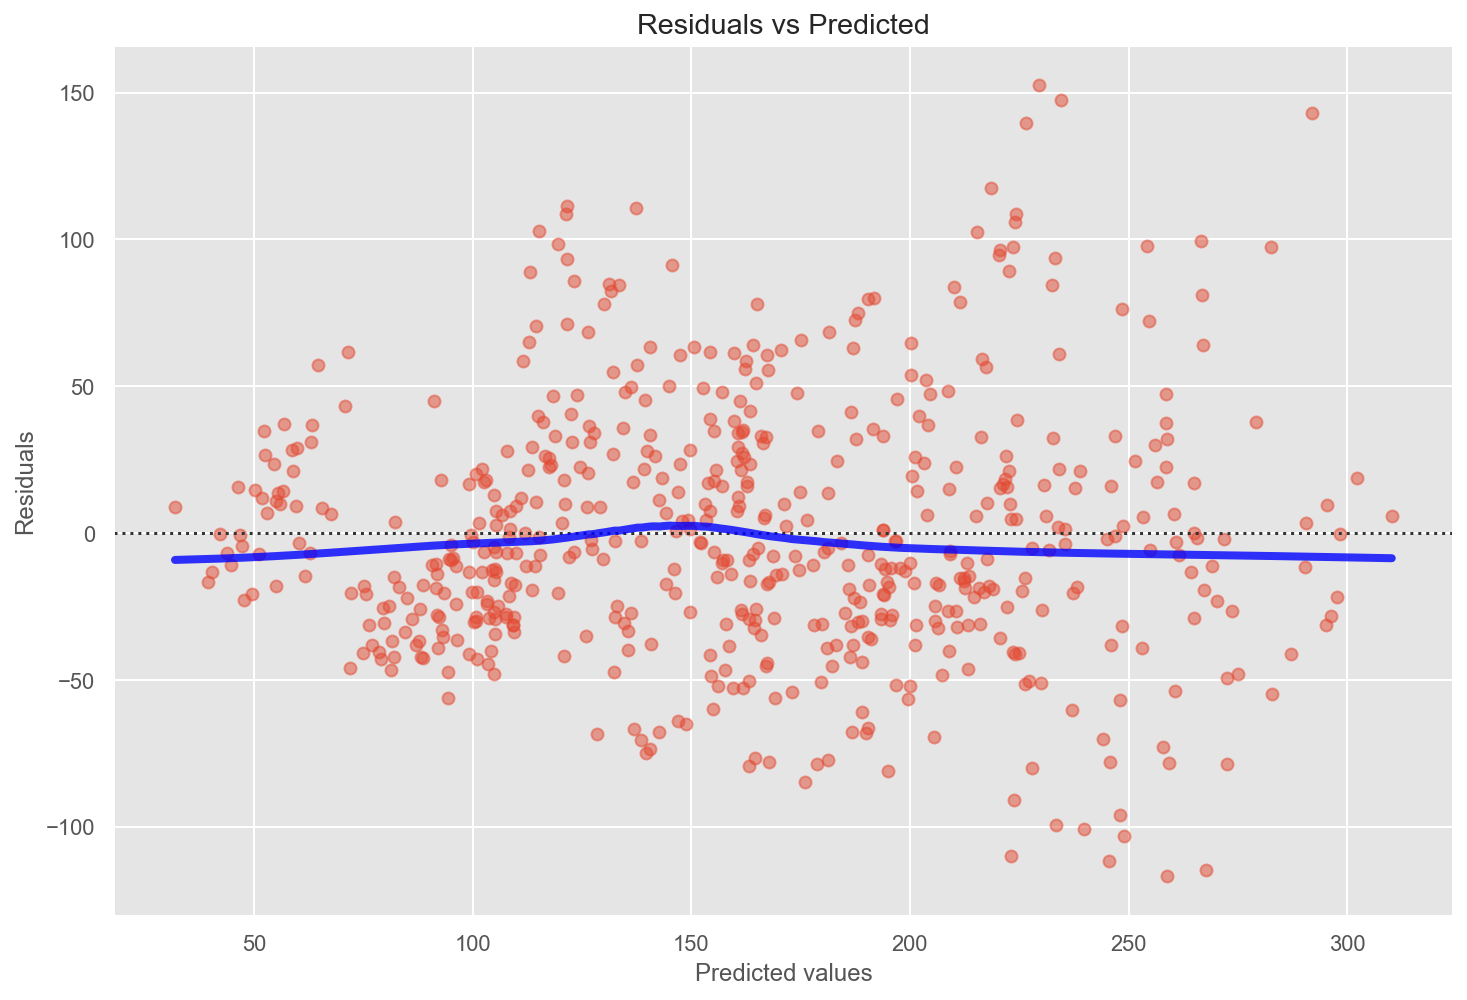

In [19]:
def plot_residuals_vs_predicted(model_fit, X, y):
    
    dataframe = pd.concat([X, y], axis=1)

    # model values
    model_fitted_y = model_fit.predict()
    # model residuals
    model_residuals = model_fit.resid
    # normalized residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal
    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)
    # leverage, from statsmodels internals
    model_leverage = model_fit.get_influence().hat_matrix_diag
    # cook's distance, from statsmodels internals
    model_cooks = model_fit.get_influence().cooks_distance[0]


    plot_lm_1 = plt.figure(figsize=(12,8))
    plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'blue', 'lw': 4, 'alpha': 0.8})

    plot_lm_1.axes[0].set_title('Residuals vs Predicted')
    plot_lm_1.axes[0].set_xlabel('Predicted values')
    plot_lm_1.axes[0].set_ylabel('Residuals');
    
    
    
plot_residuals_vs_predicted(model_1_fit, X_train_val, y_train_val)

In [20]:
X_new = sm.add_constant(X_test)
rmse = np.sqrt(mean_squared_error(y_test, model_1_fit.predict(X_new) ))
print('RMSE of model 1 : ', rmse)

RMSE of model 1 :  40.01269857057864


### Plot Cooks Distance to detect outliers

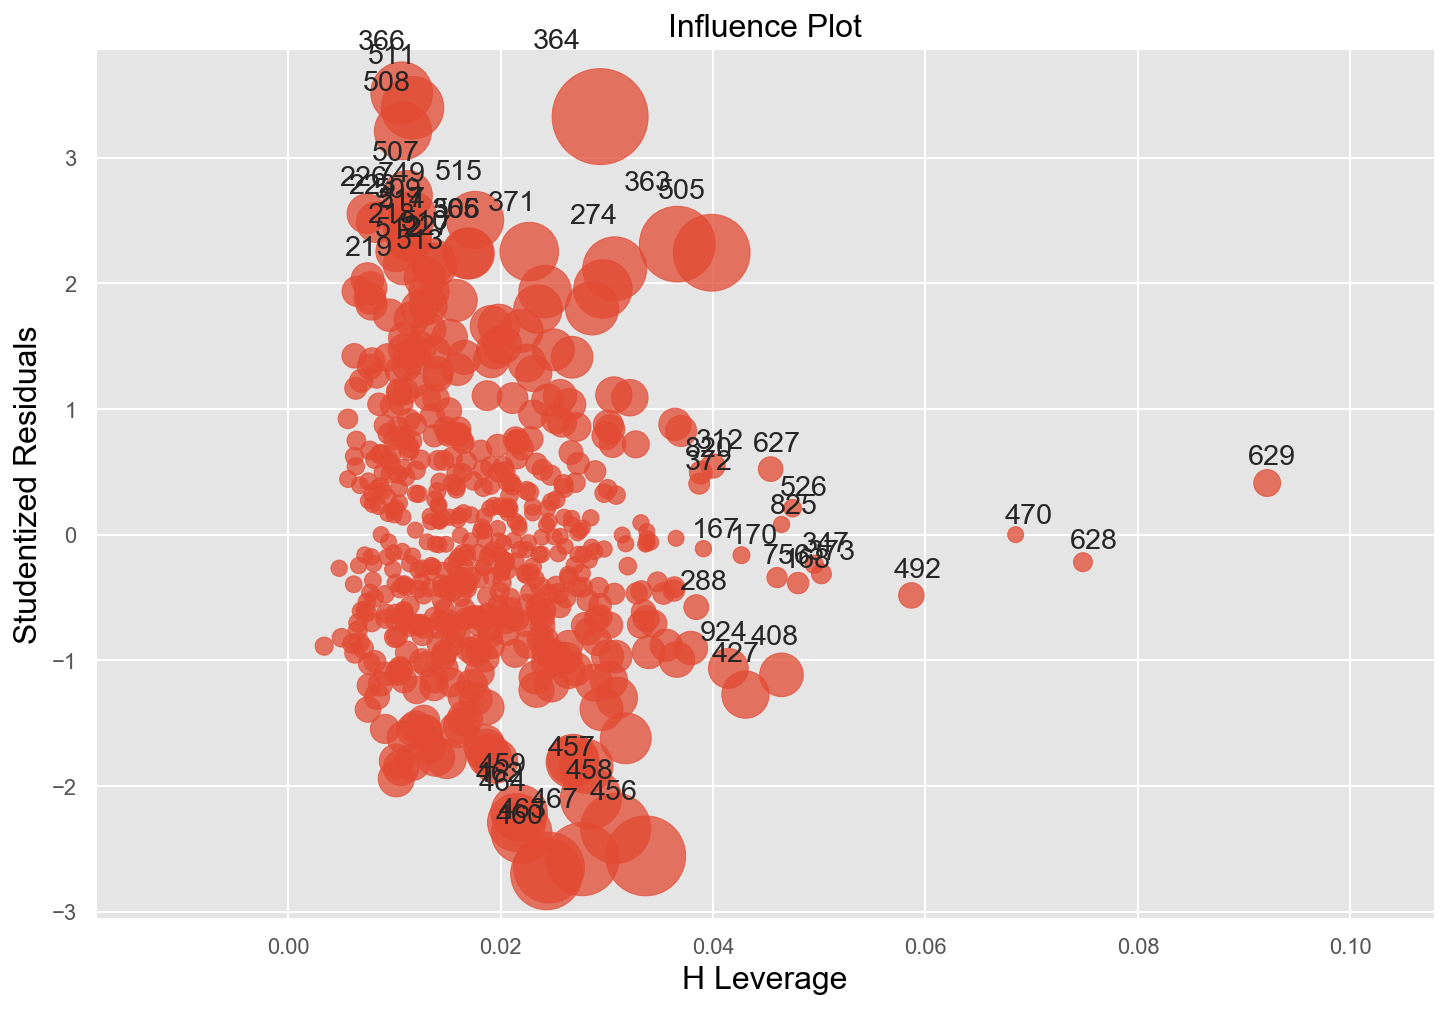

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model_1_fit, alpha  = 0.05, ax = ax, criterion="cooks")

In [22]:
infl = model_1_fit.get_influence()
sm_fr = infl.summary_frame()
sm_fr.head(3)

,dfb_const,dfb_percent_accident_at_night,dfb_percent_accident_in_snow,dfb_lat,dfb_lng,dfb_population,dfb_density,dfb_num_potholes,dfb_percent_traffic_related_crime,dfb_num_crime,dfb_intersection_count,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
327,0.031834,-0.007087,0.003337,0.018932,0.032810,0.004600,-0.017334,0.018660,0.000212,-0.008973,0.005650,0.000222,0.623098,0.006245,0.049395,0.622760,0.049368
398,0.001874,-0.002718,0.010288,0.000043,0.001495,0.005175,-0.011200,-0.032550,-0.017097,0.003711,0.003356,0.000196,-0.536103,0.007429,-0.046379,-0.535764,-0.046350
581,-0.025407,-0.025467,-0.008526,-0.007277,-0.023350,0.058500,0.001203,-0.028405,-0.014853,0.005182,-0.030012,0.000847,0.877546,0.011952,0.096516,0.877367,0.096497


### B2. Explore other features in the data

In [23]:
X2 = X.copy()

X2['population2'] = X2['population'] ** 2

X2['num_crime_/_num_intersection'] = X2['num_crime'] / X2['intersection_count']

X2['intersection_count5'] = X2['intersection_count'] ** 5

X2['num_crime_x_num_pothole'] = X2['num_crime'] * X2['num_potholes']

In [24]:
split_and_validate(X2, y)


Train R^2 score was: 0.7465677013645713

Validation R^2 score was: 0.7505576728834923

Feature coefficient results: 

percent_accident_at_night : -0.02
percent_accident_in_snow : -0.02
lat : -0.02
lng : 0.00
population : -0.00
density : 0.01
num_potholes : -0.01
percent_traffic_related_crime : -0.02
num_crime : 0.13
intersection_count : 0.17
population2 : 0.00
num_crime_/_num_intersection : 5.15
intersection_count5 : -0.00
num_crime_x_num_pothole : 0.00


#'num_accident', 'population', 'density',
#'num_potholes', 'percent_traffic_related_crime', 
#'num_traffic_related_crime', 'intersection_count'

plt.plot(X_test['intersection_count'],X_test['price'],'.',
        X_test['intersection_count'],model.predict(X_test),'-')

In [25]:
# hold out 60%, 20% and 20% of  for the train, validation and test data
X2_train_val, X2_test, y_train_val, y_test = train_test_split(X2, y, test_size=.2, random_state=10)
X2_train, X2_val, y_train, y_val = train_test_split(X2_train_val, y_train_val, test_size=.20, random_state=3)

In [26]:
X2_train_val.shape, y_train_val.shape

((576, 14), (576, 1))

In [27]:
X2_test.shape, y_test.shape

((144, 14), (144, 1))

In [28]:
## Add constant and use StatsModels to generate an OLS regression model
model_2 = sm.OLS(y_train_val, sm.add_constant(X2_train_val))
model_2_fit = model_2.fit()
model_2_fit.summary()

/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           num_accident   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     174.0
Date:                Sat, 20 Jul 2019   Prob (F-statistic):          1.17e-156
Time:                        04:44:16   Log-Likelihood:                -2921.1
No. Observations:                 576   AIC:                             5862.
Df Residuals:                     566   BIC:                             5906.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.0004      0.001      0.525      0.600      -0.001       0.002
percent_accident_at_night         0.0061      0.001      8.048      0.000       0.005       0.008
percent_accident_in_snow         -0.0070      0.001     -7.007      0.000      -0.009      -0.005
lat                              -0.0009      0.034     -0.026      0.979      -0.067       0.065
lng                              -0.0362      0.067     -0.538      0.591      -0.168       0.096
population                       -0.0010      0.000     -4.106      0.000      -0.001      -0.001
density                           0.0070      0.001     10.166      0.000       0.006       0.008
num_potholes                     -0.0064      0.004     -1.772      0.077      -0.013       0.001
percent_traffic_related_crime    -0.0165      0.002     -6.817      0.000      -0.021      -0.012
num_crime                         0.1352      0.010     13.723      0.000       0.116       0.155
intersection_count                0.1818      0.016     11.367      0.000       0.150       0.213
population2                    1.396e-08      2e-09      6.976      0.000       1e-08    1.79e-08
num_crime_/_num_intersection      5.4511      0.762      7.153      0.000       3.954       6.948
intersection_count5           -6.056e-14   5.03e-15    -12.041      0.000   -7.04e-14   -5.07e-14
num_crime_x_num_pothole        1.122e-05    7.5e-06      1.497      0.135    -3.5e-06    2.59e-05
==============================================================================
Omnibus:                       24.256   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.435
Skew:                           0.524   Prob(JB):                     1.82e-06
Kurtosis:                       3.065   Cond. No.                     1.01e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+18. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Plot Cooks Distance to detect outliers

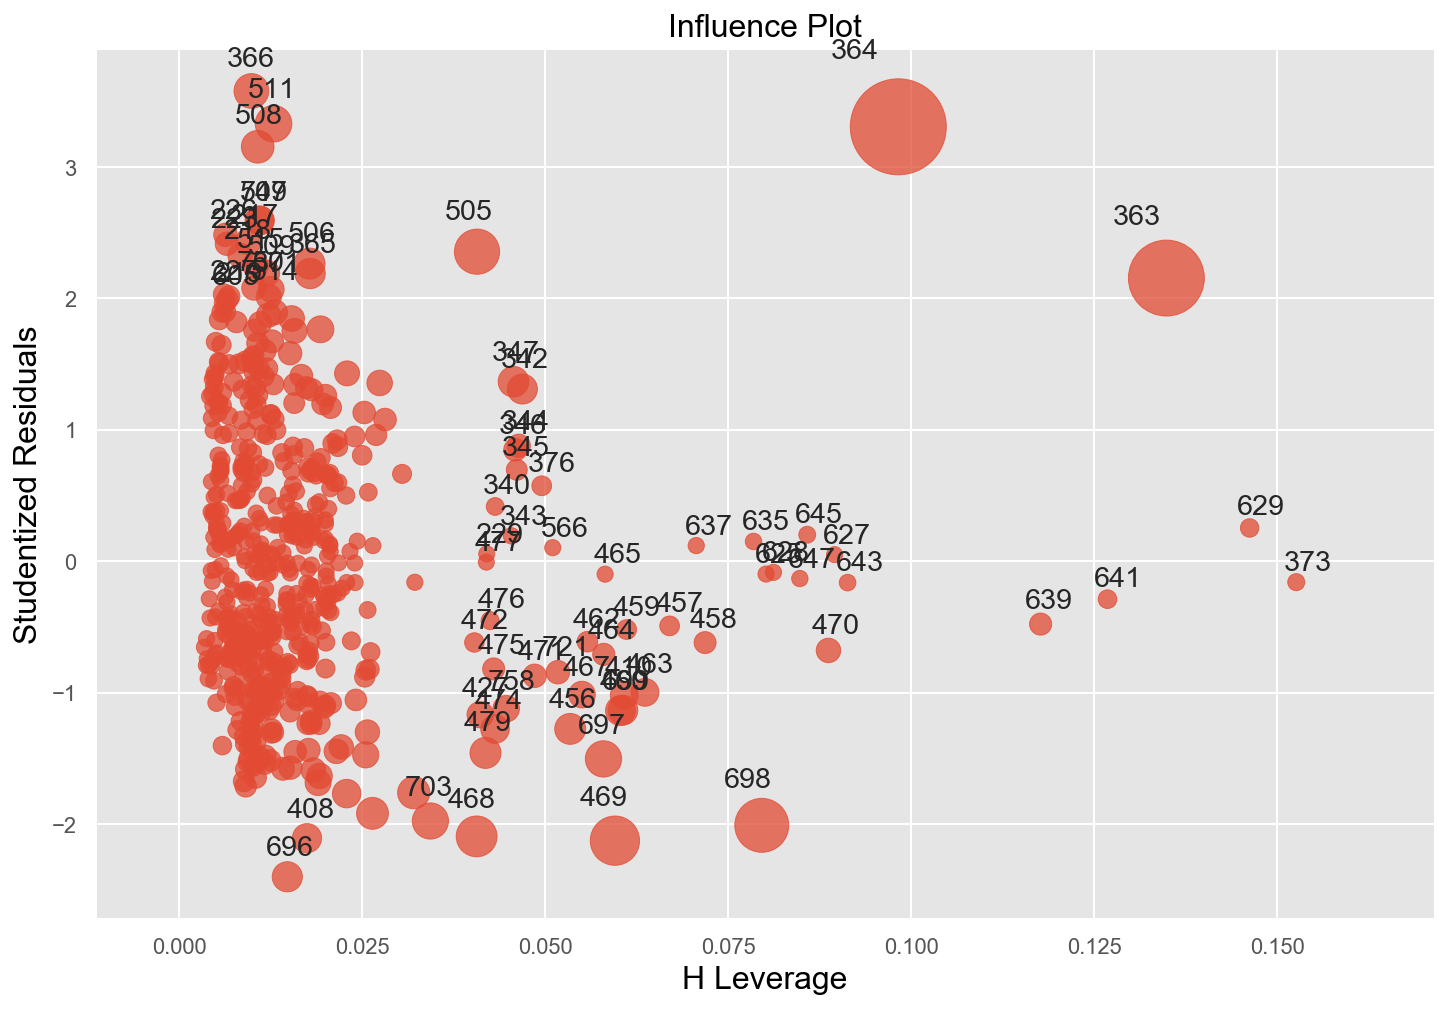

In [29]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model_2_fit, alpha  = 0.05, ax = ax, criterion="cooks")

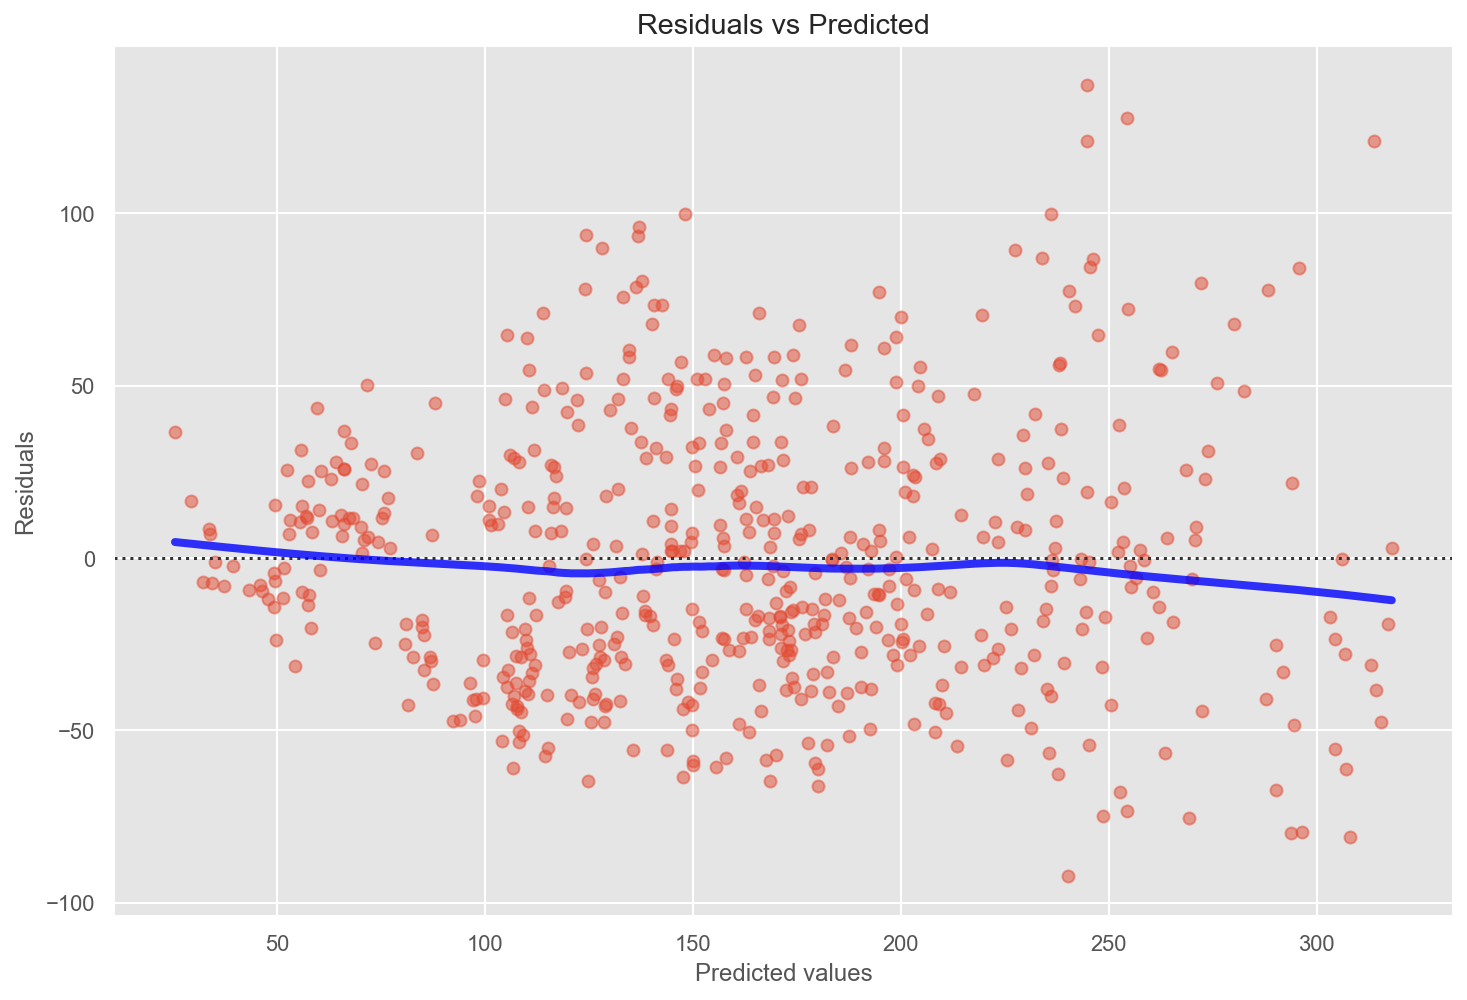

In [30]:
plot_residuals_vs_predicted(model_2_fit, X2_train_val, y_train_val)

In [31]:
X2_new = sm.add_constant(X2_test)
rmse = np.sqrt(mean_squared_error(y_test, model_2_fit.predict(X2_new) ))
print('RMSE of model 2 : ', rmse)

RMSE of model 2 :  34.38947978507306


### Plot predicion vs observed output

/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Text(0.5, 0, 'true number of crash')

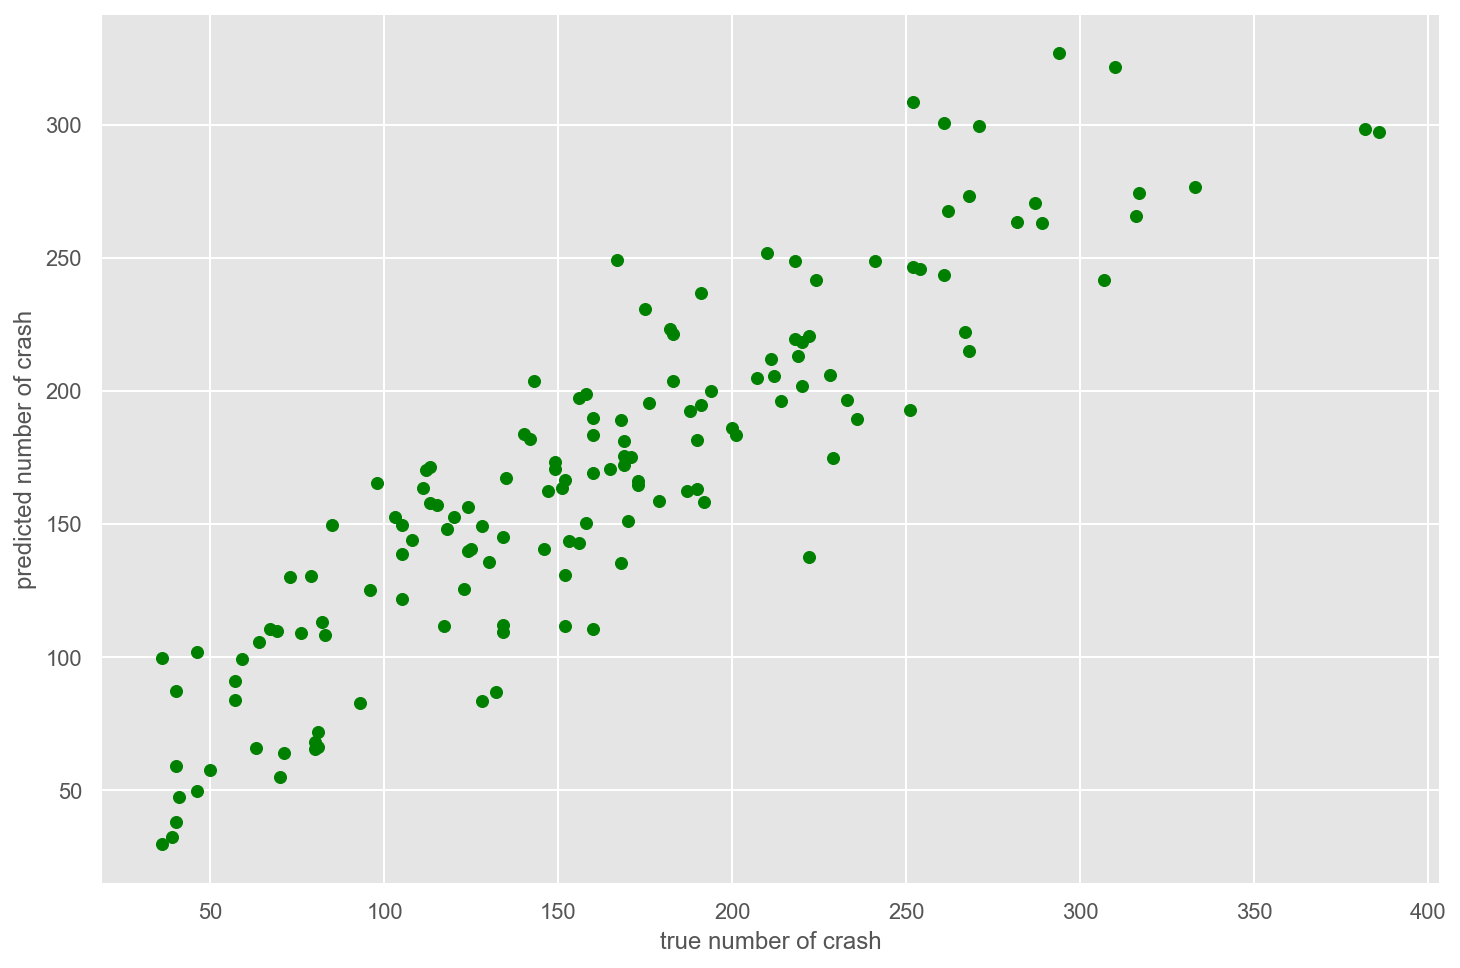

In [32]:
predictions = model_2_fit.predict(sm.add_constant(X2_test))

plt.figure(figsize=(12,8))
plt.scatter(y_test,predictions, color='green')
plt.ylabel('predicted number of crash')
plt.xlabel('true number of crash')

# C. Polynomial model

In [33]:
from sklearn.preprocessing import PolynomialFeatures

def build_polynomial_model(X_train, X_val, X_test, y_train, y_val, y_test, degree = 2,  color='red'):
    
    #Feature scaling for train, val, and test so that we can run our ridge model on each
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train.values)
    X_val_scaled = scaler.transform(X_val.values)
    X_test_scaled = scaler.transform(X_test.values)

    lm_poly = LinearRegression()

    #Feature transforms for train, val, and test so that we can run our poly model on each
    poly = PolynomialFeatures(degree=degree) 

    X_train_poly = poly.fit_transform(X_train.values)
    X_val_poly = poly.transform(X_val.values)
    X_test_poly = poly.transform(X_test.values)
    
    
    lm_poly.fit(X_train_poly, y_train)
    
    print(f'Degree {degree:d} polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')
    print(f'Degree {degree:d} polynomial regression test R^2: {lm_poly.score(X_test_poly, y_test):.3f}')
    
    
    plt.figure(figsize=(12,8))
    plt.scatter(y_test, lm_poly.predict(X_test_poly), color=color)
    plt.ylabel('predicted number of crash')
    plt.xlabel('true number of crash')
    plt.show()
        

### C1. Calculate $R^2$ for feature X  

Degree 2 polynomial regression val R^2: 0.814
Degree 2 polynomial regression test R^2: 0.812


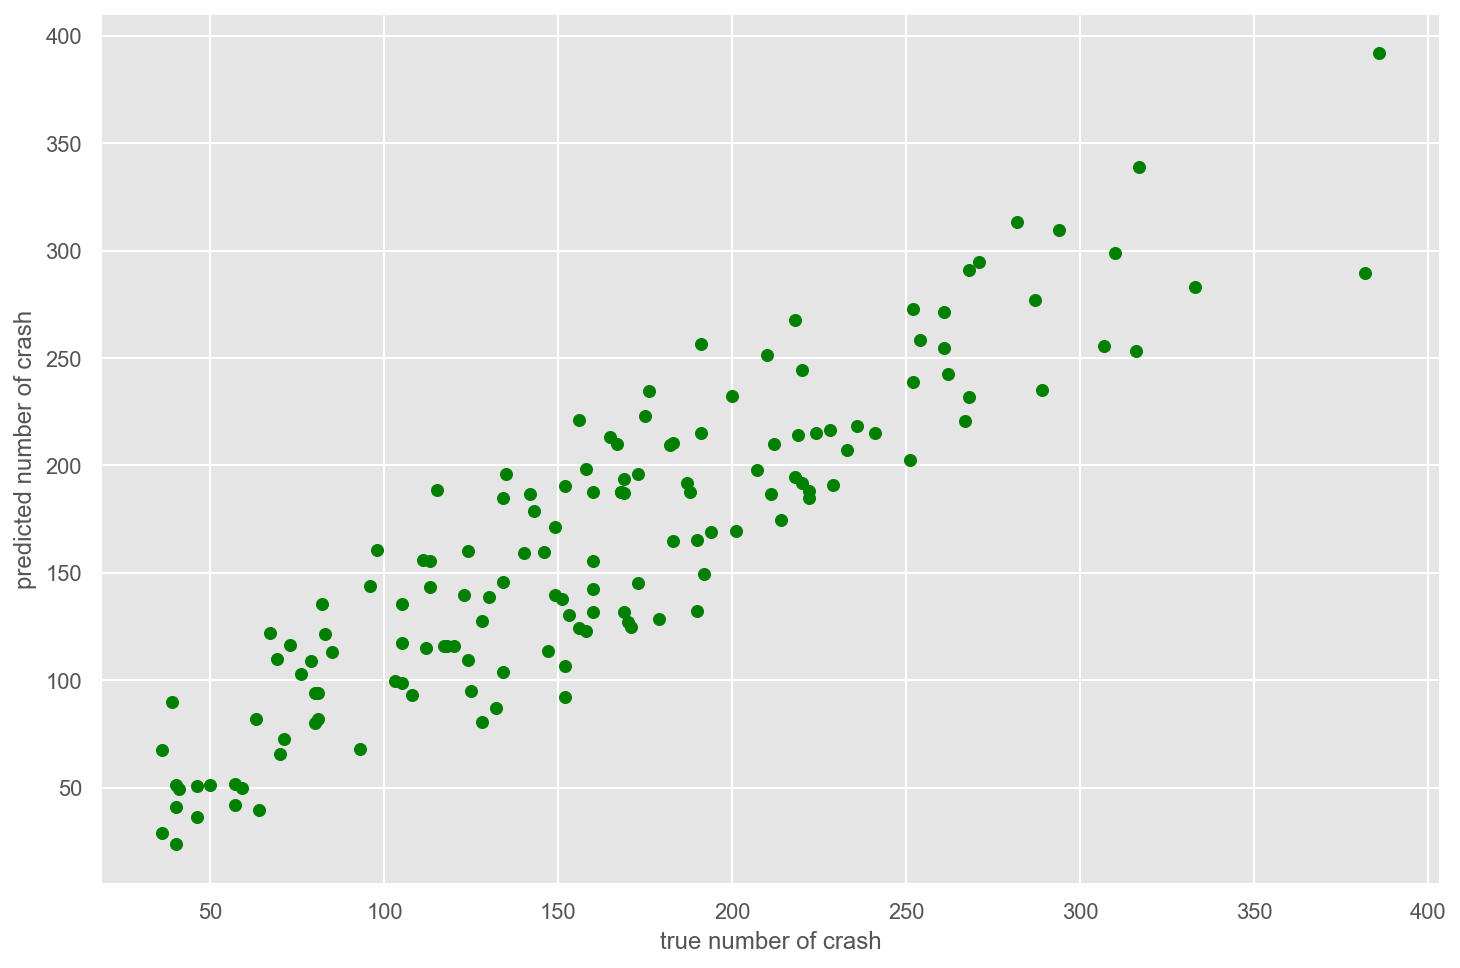

In [34]:
build_polynomial_model(X_train, X_val, X_test, y_train, y_val, y_test, degree = 2, color='green')

Apparently, the ***$R^2$ score came out to be 0.812*** and the plot came to look like this. Clearly, the polynomial features of degree 2 helped to fit the data much better rather than simple linear features.

I play around with the ***degree = 3*** for the polynomial features. The ***$R^2$ score came out to be 0.405*** and degree 3 features is not much useful.

Degree 3 polynomial regression val R^2: 0.320
Degree 3 polynomial regression test R^2: 0.405


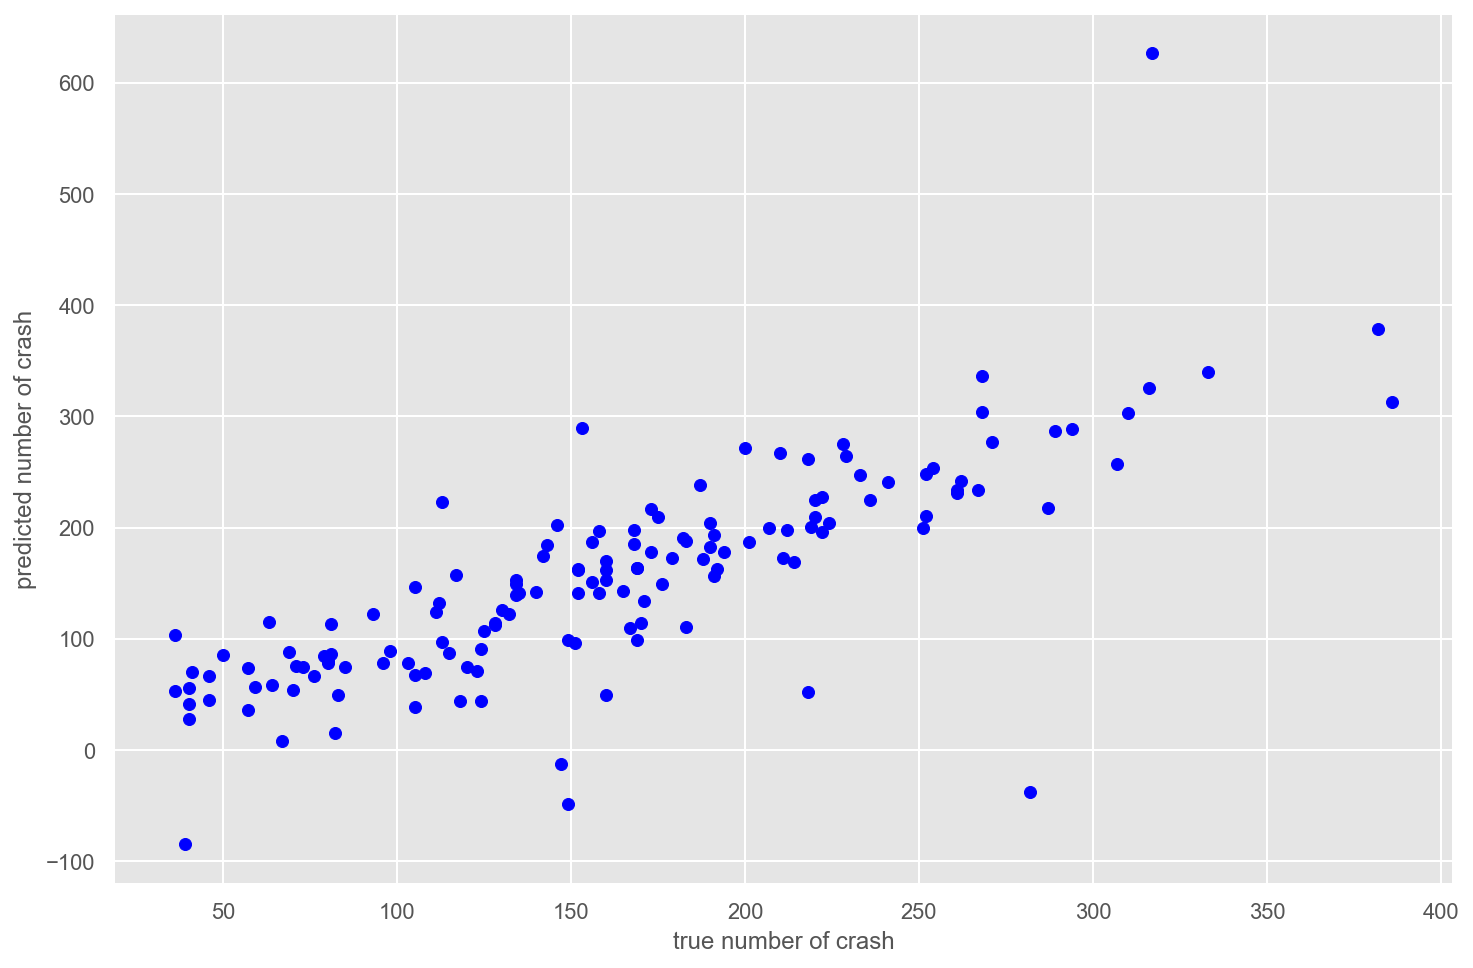

In [35]:
build_polynomial_model(X_train, X_val, X_test, y_train, y_val, y_test, degree = 3, color='blue')

### C2. Calculate $R^2$ for additional features X2 

Degree 2 polynomial regression val R^2: 0.440
Degree 2 polynomial regression test R^2: 0.382


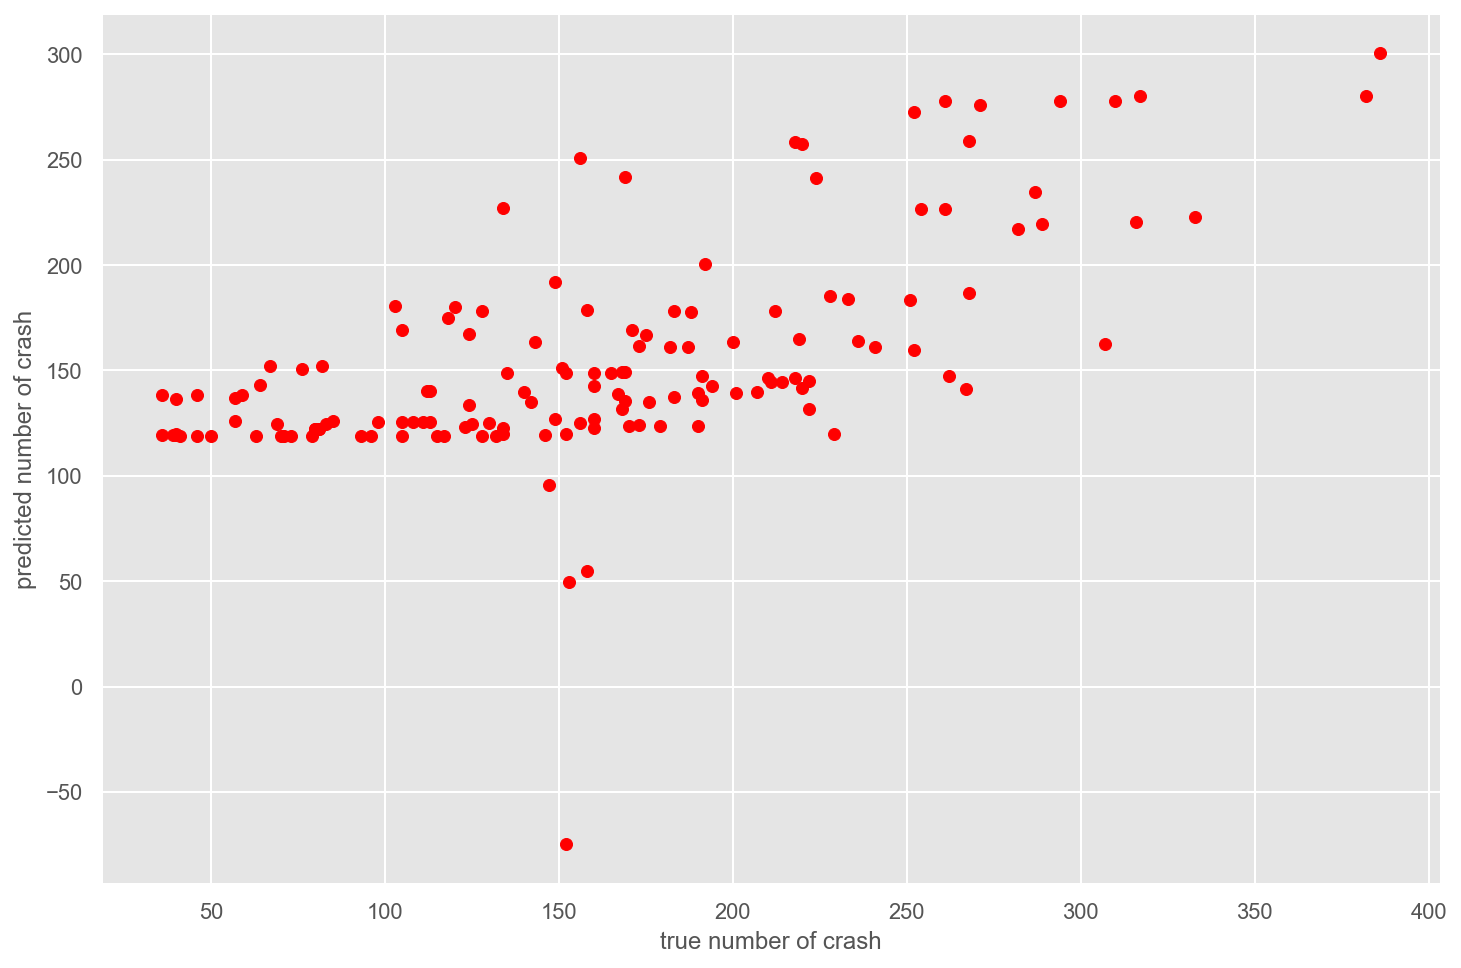

In [36]:
build_polynomial_model(X2_train, X2_val, X2_test, y_train, y_val, y_test, color='red')

The ***$R^2$ score came out to be very low 0.382***. Clearly, the polynomial features of degree 2 did not help to fit the data compared to simple linear features.

***Degree = 3 is even worse***

Degree 3 polynomial regression val R^2: -0.074
Degree 3 polynomial regression test R^2: -0.261


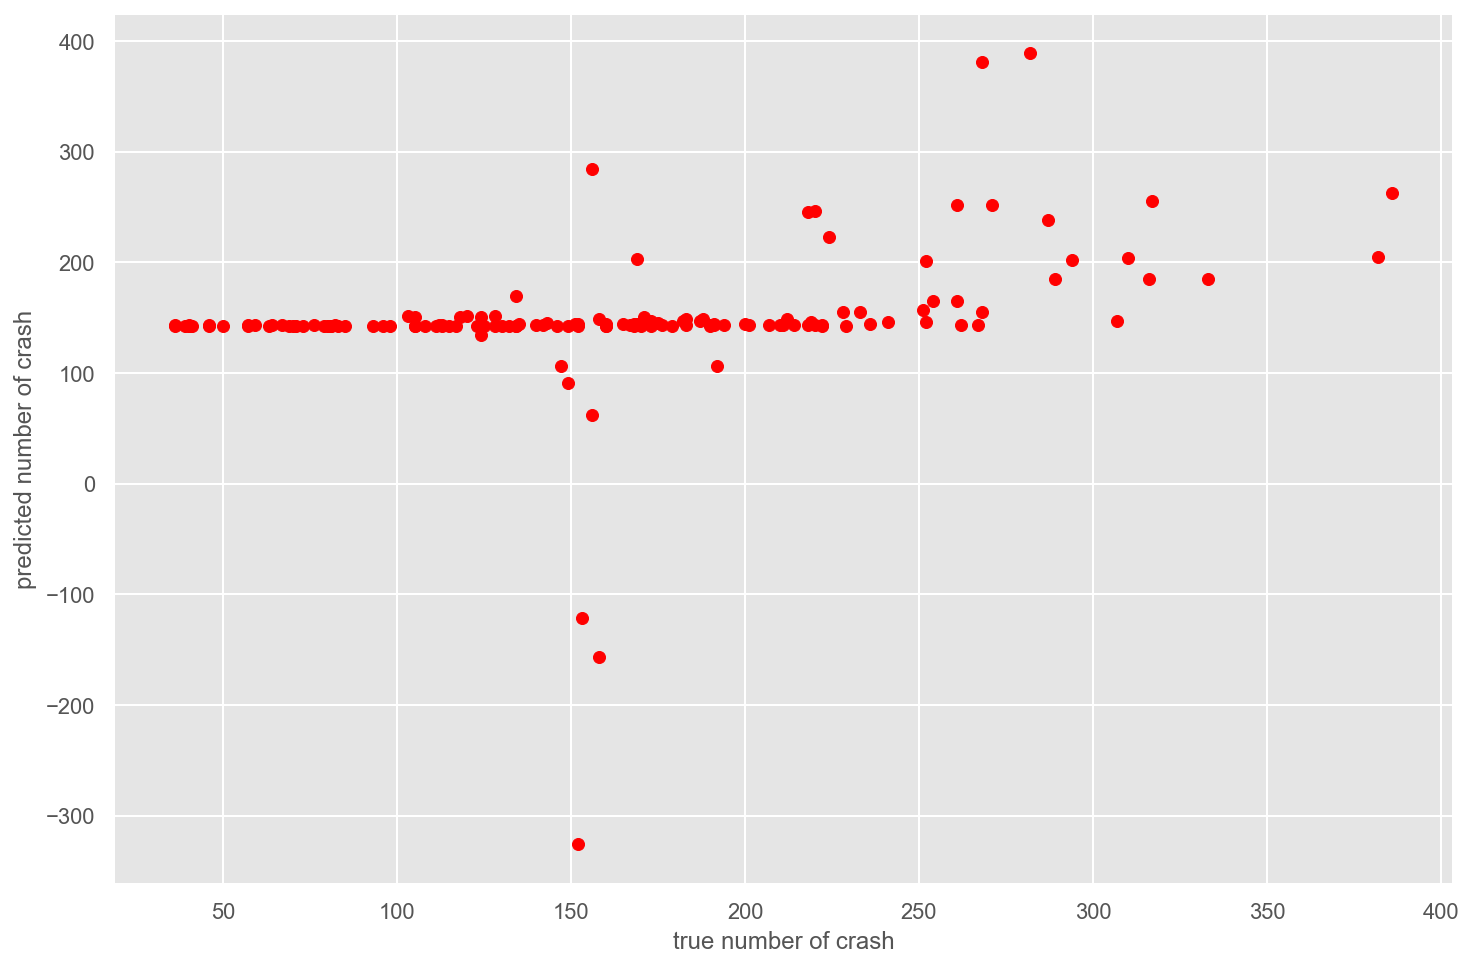

In [37]:
build_polynomial_model(X2_train, X2_val, X2_test, y_train, y_val, y_test, degree =3 ,color='red')

# D. Lasso regression

###  KFold

In [38]:
kf = KFold(n_splits=5, shuffle=True, random_state = 44)

### Lasso

In [39]:
def lasso_search_grid(X, y):
    train_r2_mean = []
    val_r2_mean = []

    train_rmse = []
    val_rmse = []   
    

    for alpha in range(-6,6):
    #for alpha in alphas:    

        print('\nAlpha:', alpha)
    
        train_r2 = []
        val_r2 = []
    
        for train_ind, val_ind in kf.split(X,y):

            X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
            X_val, y_val = X.iloc[val_ind], y.iloc[val_ind] 
        
            #Feature scaling for train, val, and test so that we can run our ridge model on each
            scaler = StandardScaler()

            X_train = scaler.fit_transform(X_train.values)
            X_val = scaler.transform(X_val.values)
        
            lasso = Lasso(10**alpha)
            lasso.fit(X_train, y_train)

            train_r2.append(lasso.score(X_train, y_train))
            val_r2.append(lasso.score(X_val, y_val))
    

        train_r2_mean.append(np.mean(train_r2))
        val_r2_mean.append(np.mean(val_r2))
        
                
        train_rmse.append(np.sqrt(mean_squared_error(y_train,lasso.predict(X_train)))) 
        val_rmse.append(np.sqrt(mean_squared_error(y_val,lasso.predict(X_val)))) 

        print('Train R2:', np.mean(train_r2_mean).round(3))
        print('Validation R2:', np.mean(val_r2_mean).round(3))
        
    return train_r2_mean, val_r2_mean, train_rmse, val_rmse

In [40]:
def best_lasso_regularization(X_train_val, X_test, y_train_val, y_test, best_alpha = 10**-1):
    

    best_lasso = Lasso(best_alpha)
    best_lasso.fit(X_train_val, y_train_val)
        
    best_lasso.score(X_test, y_test)
    
    
    print('intercept of lasso regression :', best_lasso.intercept_)
    print('coefficents of lasso regression : ', best_lasso.coef_) 
    
    print('R2 for test data', best_lasso.score(X_test, y_test))

    
    
def lasso_r2(X_train_subset, X_test_subset, y_train, y_test ):
    lr = LinearRegression()
    lr.fit(X_train_subset, y_train)
    
    print(f'Train R^2: {lr.score(X_train_subset, y_train):.3f}')
    print(f'Test R^2: {lr.score(X_test_subset, y_test):.3f}')

### D1. Build Lasso regularization for feature X

In [41]:
train_r2_mean, test_r2_mean, train_rmse, test_rmse  = lasso_search_grid(X_train_val, y_train_val)


Alpha: -6
Train R2: 0.662
Validation R2: 0.642

Alpha: -5
Train R2: 0.662
Validation R2: 0.642

Alpha: -4
Train R2: 0.662
Validation R2: 0.642

Alpha: -3
Train R2: 0.662
Validation R2: 0.642

Alpha: -2
Train R2: 0.662
Validation R2: 0.642

Alpha: -1
Train R2: 0.662
Validation R2: 0.642

Alpha: 0
Train R2: 0.662
Validation R2: 0.642

Alpha: 1
Train R2: 0.654
Validation R2: 0.636

Alpha: 2
Train R2: 0.582
Validation R2: 0.565

Alpha: 3
Train R2: 0.524
Validation R2: 0.508

Alpha: 4
Train R2: 0.476
Validation R2: 0.461

Alpha: 5
Train R2: 0.436
Validation R2: 0.422


### Best LASSO

In [42]:
best_lasso_regularization(X_train_val, X_test, y_train_val, y_test, best_alpha = 10**-1)

intercept of lasso regression : [-1779.60500851]
coefficents of lasso regression :  [-2.43007149e+00 -2.96476579e+01  4.29488475e+01  0.00000000e+00
  1.00252352e-03  3.58182452e-03  1.62173083e-03  3.89177313e+01
  1.50269550e-01  2.95343576e-02]
R2 for test data 0.7214982249190012


In [43]:
#X2_test.shape, y_test.shape
X_test.shape, y_test.shape

((144, 10), (144, 1))

### Build Linear Regression for best features 

In [44]:
X_train_subset = X_train.iloc[:, [2,4,5,8,9]]
X_test_subset = X_test.iloc[:, [2,4,5,8,9]]
#X_train_subset = X_train
#X_test_subset = X_test

In [45]:
lasso_r2(X_train_subset, X_test_subset, y_train, y_test )

Train R^2: 0.648
Test R^2: 0.715


### D2. Build Lasso regularization for feature X2

In [46]:
train_r2_mean, val_r2_mean, train_rmse, val_rmse = lasso_search_grid(X2_train_val, y_train_val)


Alpha: -6
Train R2: 0.743
Validation R2: 0.73

Alpha: -5
Train R2: 0.743
Validation R2: 0.73

Alpha: -4
Train R2: 0.743
Validation R2: 0.73

Alpha: -3
Train R2: 0.743
Validation R2: 0.73

Alpha: -2
Train R2: 0.743
Validation R2: 0.73

Alpha: -1
Train R2: 0.743
Validation R2: 0.73

Alpha: 0
Train R2: 0.741
Validation R2: 0.728

Alpha: 1
Train R2: 0.725
Validation R2: 0.713

Alpha: 2
Train R2: 0.645
Validation R2: 0.633

Alpha: 3
Train R2: 0.58
Validation R2: 0.569

Alpha: 4
Train R2: 0.528
Validation R2: 0.516

Alpha: 5
Train R2: 0.484
Validation R2: 0.473


### Best LASSO

In [47]:
best_lasso_regularization(X2_train_val, X2_test, y_train_val, y_test, best_alpha = 10**-2)

intercept of lasso regression : [5495.96431298]
coefficents of lasso regression :  [ 1.61271787e+01 -5.46698331e+01  5.95198491e+01  9.11932074e+01
 -9.19266526e-04  5.86908193e-03 -5.59175702e-03  4.65729280e+01
  1.24861367e-01  1.83012495e-01  1.35468435e-08  5.74864483e+00
 -6.08924394e-14  1.21143257e-05]
R2 for test data 0.8025380298661347


In [48]:
X2_train_subset = X2_train.iloc[:, [2,3,7,11]]
X2_test_subset = X2_test.iloc[:, [2,3,7,11]]
X2_train_subset = X2_train
X2_test_subset = X2_test

In [49]:
lasso_r2(X2_train_subset, X2_test_subset, y_train, y_test )

Train R^2: 0.733
Test R^2: 0.804


# D. LARS model selection 


- LARS is a method for finding the entire regularization path (changing beta in Rajat's answer from 0 to infinity) in a way that is nearly as computationally efficient as lasso.



- LARS shrinks the coefficients towards zero in a data-dependent way 



- It computes the whole regularization path solutions with the same complexity as OLS


In [50]:
from sklearn.linear_model import lars_path

In [51]:
## Scale the variables
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)

In [52]:
## Note: lars_path takes numpy matrices, not pandas dataframes
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values.T[0], method='lasso')

Computing regularization path using the LARS ...


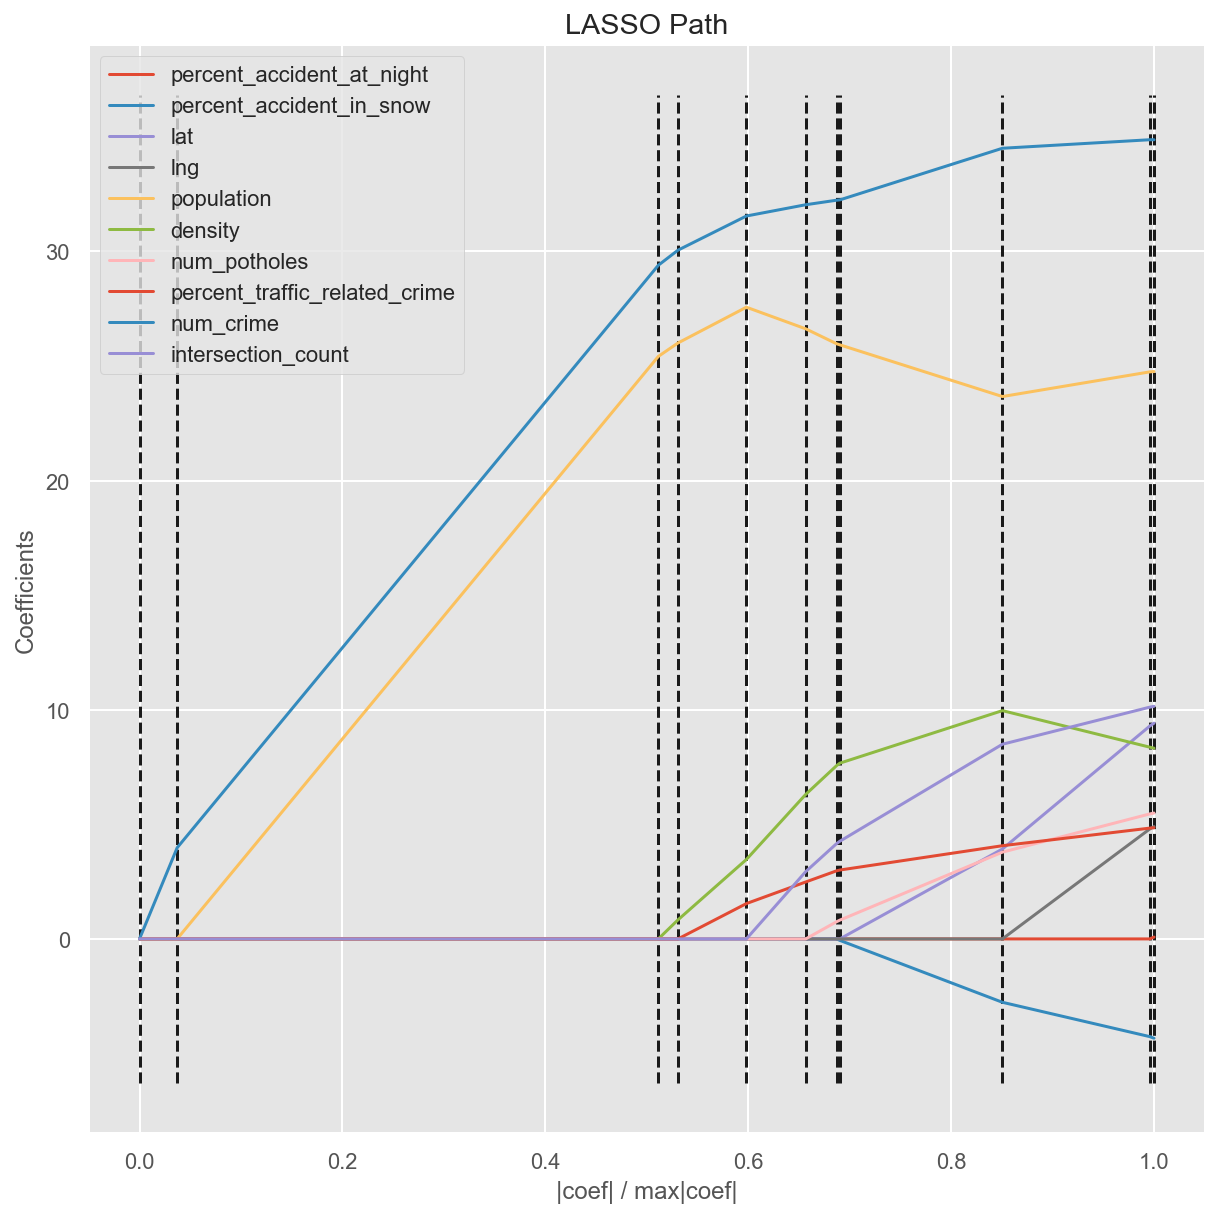

In [53]:
# plotting the LARS path
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
#plt.legend(X2.columns[[5,8,9,10,11,13]])
plt.legend(X.columns)
plt.show()

### The ***most important feature*** for model is `num_crime`

# E. Predict number of accidents for a specific case

In [54]:
test_index = X_test.index


# Predict car accident at zipcode 60616 in December
test_id = test_index[10]

crash1 = df['id'].loc[test_id]

zipcode1 = crash1[0]
month1 = crash1[1]


print(f'Crash 1 at zipcode is {zipcode1 :.0f} and month is {month1 : .0f}')

predictions2 = model_2_fit.predict(sm.add_constant(X2_test))

print(f'The real accident at zipcode {zipcode1 : .0f} in {month1 : .0f} is {y_test.num_accident[test_id] : .0f}')
print(f'The predicted accident at zipcode {zipcode1 : .0f} in {month1 : .0f} is {predictions2[test_id]: .0f}')

Crash 1 at zipcode is 60616 and month is  12
The real accident at zipcode  60616 in  12 is  187
The predicted accident at zipcode  60616 in  12 is  162


/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [55]:
# Predict car accident at zipcode 60637 in December
test_id = test_index[-34]

crash1 = df['id'].loc[test_id]

zipcode1 = crash1[0]
month1 = crash1[1]

print(f'Crash 2 at zipcode is {zipcode1 :.0f} and month is {month1 : .0f}')

predictions2 = model_2_fit.predict(sm.add_constant(X2_test))

print(f'The real accident at zipcode {zipcode1 : .0f} in {month1 : .0f} is {y_test.num_accident[test_id] : .0f}')
print(f'The predicted accident at zipcode {zipcode1 : .0f} in {month1 : .0f} is {predictions2[test_id]: .0f}')

Crash 2 at zipcode is 60637 and month is  7
The real accident at zipcode  60637 in  7 is  152
The predicted accident at zipcode  60637 in  7 is  167


## Reference

https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/


https://towardsdatascience.com/how-do-you-check-the-quality-of-your-regression-model-in-python-fa61759ff685


https://towardsdatascience.com/analyze-the-data-through-data-visualization-using-seaborn-255e1cd3948e


https://towardsdatascience.com/predicting-vehicle-accidents-with-machine-learning-ce956467fa74


https://medium.com/geoai/using-machine-learning-to-predict-car-accident-risk-4d92c91a7d57